# **Step-1:** Importing Required Libraries

In [ ]:
!pip3 install -U tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import glob 
import cv2 
import os

# **Step-2:** Importing Data

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

#Capture training data and labels into respective lists
images = []
labels = []


for directory_path in glob.glob("/content/drive/MyDrive/NIT Durgapur Internship 3/Dataset_Modified/*"):
   data_split=os.path.split(directory_path)
   label=data_split[-1]
   print(label)

Hand
BreastMRI
ChestCT
CXR
AbdomenCT
HeadCT


In [ ]:
CLASSES = os.listdir('/content/drive/MyDrive/NIT Durgapur Internship 3/Dataset_Modified') 
TRAINING_DATA_SET_PATH = '/content/drive/MyDrive/NIT Durgapur Internship 3/Dataset_Modified'
TEST_DATA_SET_PATH = '/content/drive/MyDrive/NIT Durgapur Internship 3/Dataset_for_test'

# **Step-3:** Configuring the hyperparameters

In [ ]:
params = dict(
    seed = 123,
    image_dim = (288,288),
    weight_decay = 1e-4,
    epochs = 30,
    batch_size = 16,
    patch_size = 18,
    pool_size = (2,2),
    optimizer = 'Adam',
    l_rate = 0.001,
    val_split = .15,
    use_transfer_learning = False,
    use_data_aug = False,

    l2_reg = .0,
    projection_dim = 16,
    num_heads = 4,
    
    # Size of the transformer layers
    transformer_layers = 4,
    num_classes = len(CLASSES),
    mlp_head_units = [1024,512]
    
    )

In [ ]:
new_params = dict(
    num_patches = (params['image_dim'][0] // params['patch_size']) ** 2,
    transformer_units = [
    params['projection_dim'] * 2,
    params['projection_dim']],
    input_shape = (params['image_dim'][0], params['image_dim'][1], 3),

)
params.update(new_params)

 # **Step-4:** Data augmentation

In [ ]:
if params['use_data_aug']:
  data_aug_params = dict(
      da_rotation = 20,
      da_w_shift = 0.1,
      da_h_shift = 0.1,
      da_shear = 0.05,
      da_zoom = 0.05,
      da_h_flip = False,
      da_v_flip = False,
  )

  params.update(data_aug_params)

In [ ]:
# Ability to switch amount of channel to utilise pre-trained models with specific input shapes
if params['use_transfer_learning']:
  INPUT_SHAPE = (params['image_dim'][0], params['image_dim'][1], 3)
  COLOUR_MODE = 'rgb'
else:
  INPUT_SHAPE = (params['image_dim'][0], params['image_dim'][1], 3)
  COLOUR_MODE = 'rgb'


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
if params['use_data_aug']:
  datagen = ImageDataGenerator(validation_split=params['val_split'], rescale=1./255,  
                               rotation_range=params['da_rotation'],
                               width_shift_range=params['da_w_shift'],
                               height_shift_range=params['da_h_shift'],
                               shear_range=params['da_shear'],
                               zoom_range=params['da_zoom'],
                               horizontal_flip=params['da_h_flip'],
                               vertical_flip=params['da_v_flip'],
                               fill_mode="constant",
                               cval=0
                               )
else:
  datagen = ImageDataGenerator(validation_split=params['val_split'])

In [ ]:
# Read all training and validation data into variables from directory. 
# Due to faulty quality of the given validation-set images, all images are taken from the training folder
train_generator = datagen.flow_from_directory(TRAINING_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    color_mode=COLOUR_MODE,
                                                    subset='training',
                                                    shuffle=True)

val_datagen = ImageDataGenerator(validation_split=0.15, rescale=1./255)
valid_generator = datagen.flow_from_directory(TRAINING_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    color_mode=COLOUR_MODE,
                                                    subset='validation',
                                                    shuffle=False)


Found 22967 images belonging to 6 classes.
Found 4053 images belonging to 6 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    color_mode=COLOUR_MODE,
                                                    shuffle=False)

Found 11580 images belonging to 6 classes.


# **Step-5:** Building MLP network

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# **Step-6:** Defining Patch maker

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# **Step-7:** Patch encoder

In [ ]:
# Linearly transform patches by projecting it into a
# vector of size `projection_dim` and also adds a learnable position
# embedding to the projected vector.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Image size: 288 X 288
Patch size: 18 X 18
Patches per image: 256
Elements per patch: 972


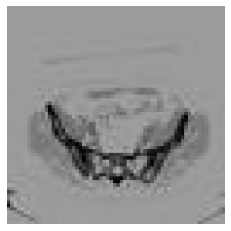

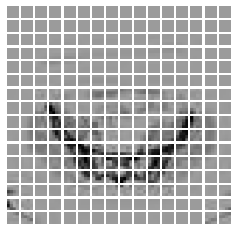

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image, label = iter(next(train_generator))
image = image[0]*255.
#image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow((image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(params['image_dim'][0], params['image_dim'][0])
)
patches = Patches(params['patch_size'])(resized_image)
print(f"Image size: {params['image_dim'][0]} X {params['image_dim'][0]}")
print(f"Patch size: {params['patch_size']} X {params['patch_size']}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (params['patch_size'], params['patch_size'], 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

# **Step-8:** Generate ViT model


In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=params['input_shape'])
    # Create patches.
    patches = Patches(params['patch_size'])(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(params['num_patches'], params['projection_dim'])(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(params['transformer_layers']):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=params['num_heads'], key_dim=params['projection_dim'], dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=params['transformer_units'], dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

# Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=params['mlp_head_units'], dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(len(CLASSES))(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# **Step-9:** Compiling & Training the Model


In [ ]:
!pip3 install wandb==0.10.11

In [ ]:
from keras import backend as K
from wandb.keras import WandbCallback

In [ ]:


# For experiment tracking
USE_WANDB = False

if USE_WANDB:
  wandb.init(tags=["ViT", "Binary"], project='dd2424', entity='teambumblebee', sync_tensorboard=True, config=params, save_code=True)
  print(params)
  wandb_callback = WandbCallback(monitor='val_f1_m', 
                                 save_model=True,
                                 save_weights_only=False, mode='max',
                                 log_weights=True,
                                 data_type="image", verbose=1, 
                                 labels=CLASSES, 
                                 generator=valid_generator,
                                 predictions=50,
                                 log_evaluation=True,
                                 log_batch_frequency=1) 
  
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=params['l_rate'], weight_decay=params['weight_decay']
    )
    
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"), f1_m, recall_m, precision_m
        ],
    )

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/NIT Durgapur Internship 3/Output/model_best_ViT.h5",
        monitor="val_f1_m",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
        mode="max"
    )

    callbacks_list = [checkpoint_callback, tf.keras.callbacks.EarlyStopping(patience=20, monitor="val_accuracy")]

    if USE_WANDB:
      callbacks_list.append(wandb_callback)


    history = model.fit(
        train_generator,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=valid_generator,
        callbacks=callbacks_list) 

    return history, model




In [ ]:
model = create_vit_classifier()
history, model = run_experiment(model)

Epoch 1/30
1436/1436 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9408 - f1_m: 0.7804 - recall_m: 0.7196 - precision_m: 0.8926
Epoch 1: val_f1_m improved from -inf to 0.89943, saving model to /content/drive/MyDrive/NIT Durgapur Internship 3/Output/model_best_ViT.h5
1436/1436 [==============================] - 1056s 730ms/step - loss: 0.1527 - accuracy: 0.9408 - f1_m: 0.7804 - recall_m: 0.7196 - precision_m: 0.8926 - val_loss: 0.0707 - val_accuracy: 0.9681 - val_f1_m: 0.8994 - val_recall_m: 0.8907 - val_precision_m: 0.9101
Epoch 2/30
1436/1436 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9907 - f1_m: 0.9713 - recall_m: 0.9633 - precision_m: 0.9802
Epoch 2: val_f1_m improved from 0.89943 to 0.93657, saving model to /content/drive/MyDrive/NIT Durgapur Internship 3/Output/model_best_ViT.h5
1436/1436 [==============================] - 1039s 724ms/step - loss: 0.0285 - accuracy: 0.9907 - f1_m: 0.9713 - recall_m: 0.9633 - precision_m: 0.98